In [3]:
import sys
sys.path.append('../src')

In [4]:
import albumentations as A
import os
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from model import Unet
from albumentations.pytorch import ToTensorV2

In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)


def get_transforms(train, mean, std):
    list_transforms = []
    list_transforms.extend(
        [
            A.Normalize(mean=mean, std=std, p=1),
            ToTensorV2(),
        ]
    )
    list_tfms = A.Compose(list_transforms)
    return list_tfms

In [6]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder):
        self.df = df
        self.root_dir = data_folder
        self.transform = get_transforms(True, mean, std)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id, rle, class_id = df.iloc[idx]
        image_path = os.path.join(self.root_dir, img_id)
        img = np.array(Image.open(image_path))
        # (256, 1600) and (1, 256, 1600, 4)
        augmented = self.transform(image=img)
        img = augmented["image"]
        return img

In [23]:
path = Path('/home/sonujha/rnd/Severstal-Steel-Defect-Detection/data/')
df = pd.read_csv(path/'sample_submission.csv')
ds = SteelDataset(df, path/'test_images')
dl = DataLoader(ds, batch_size=16, shuffle=False, pin_memory=True)

# Load the model
model = Unet("resnet18", encoder_weights="imagenet",
             classes=4, activation=None)
state = torch.load('../model.pth', map_location='cpu', weights_only=True)
model.load_state_dict(state['state_dict'])
print("==== model loaded =====")

# prediction on single image
idx = 0
img = ds[idx]
img = img[None, :, :, :]  # batch of size 1
output = model(img)
preds = torch.sigmoid(output)

==== model loaded =====


In [24]:
preds.shape, preds[0].shape

(torch.Size([1, 4, 256, 1600]), torch.Size([4, 256, 1600]))

In [25]:
import matplotlib.pyplot as plt 

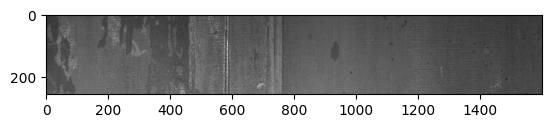

In [26]:
img_id, rle, c_id = df.iloc[idx] 
img = np.array(Image.open(os.path.join(path/'test_images', img_id)))

plt.imshow(img)

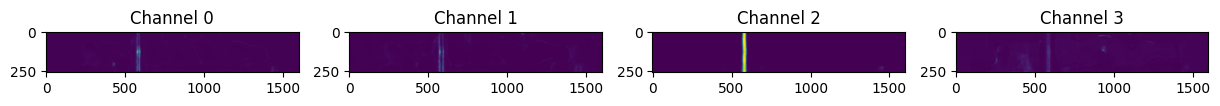

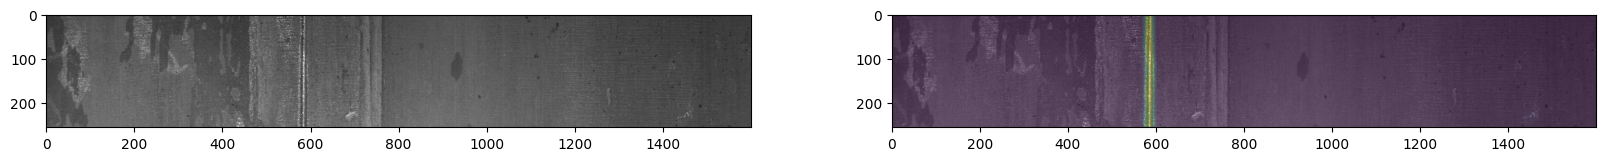

In [30]:
mask = preds[0].detach().cpu().numpy()
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(mask[i])
    axes[i].set_title(f'Channel {i}')
plt.show()
plt.figure(figsize=(20, 50))
plt.subplot(1, 2, 1)
plt.imshow(img)


plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(mask[2], alpha=0.3)
plt.show()

# Analysis on validation and train set

In [31]:
def get_transforms(train, mean, std):
    list_transforms = []
    if train:
        list_transforms.extend(
            [
                A.HorizontalFlip(p=0.5),
            ]
        )
    list_transforms.extend(
        [
            A.Normalize(mean=mean, std=std, p=1),
            ToTensorV2(),
        ]
    )
    list_tfms = A.Compose(list_transforms)
    return list_tfms


class SteelDataset(Dataset):
    def __init__(self, df, data_folder):
        self.df = df
        self.root_dir = data_folder
        self.transform = get_transforms(True, mean, std)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id, mask = img_mask_pair(idx, self.df)
        image_path = os.path.join(self.root_dir, img_id)
        img = np.array(Image.open(image_path))
        # (256, 1600) and (1, 256, 1600, 4)
        augmented = self.transform(image=img, mask=mask)
        img = augmented["image"]
        mask = augmented["mask"]
        mask = mask.permute(2, 0, 1)  # (4, 256, 1600)
        return img, mask



In [34]:
from utils import img_mask_pair
path = Path("/home/sonujha/rnd/Severstal-Steel-Defect-Detection/data/")
df = pd.read_csv(path / "train.csv")
df = df.pivot(index="ImageId", columns="ClassId", values="EncodedPixels")
ds = SteelDataset(df, path/'train_images')
x, y = ds[0]
print(x.shape, y.shape)

torch.Size([3, 256, 1600]) torch.Size([4, 256, 1600])


In [35]:
train_dl = DataLoader(
    ds, batch_size=32, num_workers=2, pin_memory=True, shuffle=True
)

In [117]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([32, 3, 256, 1600]), torch.Size([32, 4, 256, 1600]))

In [118]:
output = model(xb)
output.shape

torch.Size([32, 4, 256, 1600])

In [119]:
from utils import metric 
preds = torch.sigmoid(output) 
dice, dice_neg, dice_pos, num_neg, num_pos = metric(preds, yb)

In [120]:
p_0 = preds[0].detach().cpu().numpy() 
y_0 = yb[0].detach().cpu().numpy()
p_0.shape, y_0.shape

((4, 256, 1600), (4, 256, 1600))

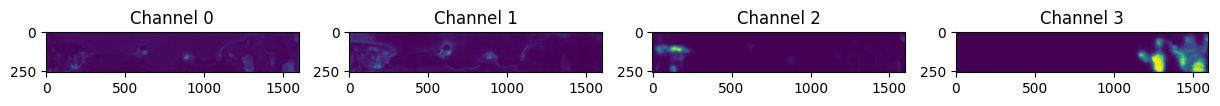

In [121]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(p_0[i])
    axes[i].set_title(f'Channel {i}')
plt.show()

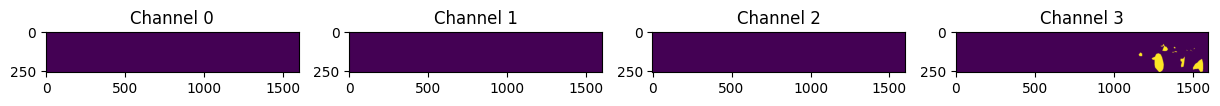

In [122]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(y_0[i])
    axes[i].set_title(f'Channel {i}')
plt.show()

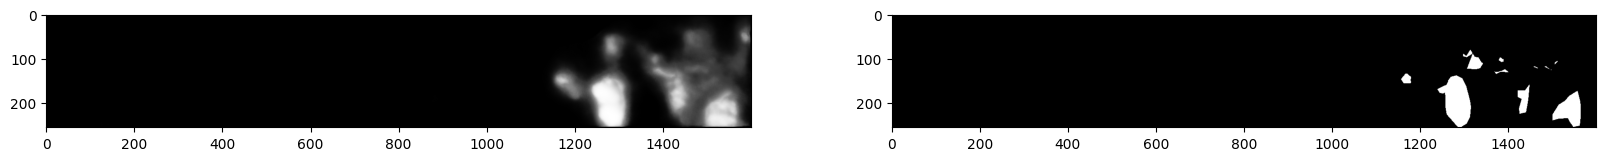

In [137]:
idx = 3
p_mask = p_0[idx]
o_mask = y_0[idx]

plt.figure(figsize=(20, 40))
plt.subplot(1, 2, 1)
plt.imshow(p_mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(o_mask, cmap='gray')
plt.show()

In [138]:
p = preds[0][idx].view(-1) 
y = yb[0][idx].view(-1)

In [139]:
p = (p > 0.5).float()
y = (y > 0.5).float() 

In [146]:
# Detach and convert to NumPy and GET IOU
p_np = p.detach().cpu().numpy()
y_np = y.detach().cpu().numpy()

# Binarize the masks
p_bin = (p_np > threshold).astype(np.uint8)
y_bin = (y_np > threshold).astype(np.uint8)

# Compute intersection and union
intersection = p_bin & y_bin
union = p_bin | y_bin

# Calculate IoU
intersection_sum = intersection.sum()
union_sum = union.sum()

if union_sum == 0:
    print(float('nan'))  # Or define as 1.0 if appropriate

iou = intersection_sum / union_sum
print(iou)

0.5484194122885129


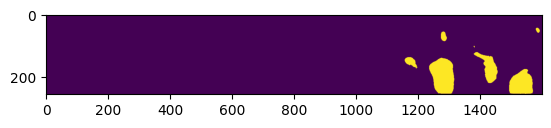

In [158]:
plt.imshow(p.reshape(256, 1600))

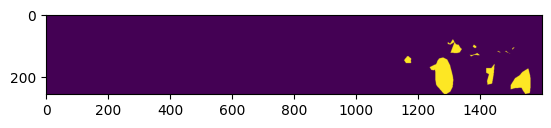

In [159]:
plt.imshow(y.reshape(256, 1600))

In [153]:
intersection.sum()

np.uint64(9854)

In [155]:
len(p)

409600

In [156]:
union.sum()

np.uint64(17968)

In [172]:
print(preds.shape)
p1 = preds.view(32, -1)
y1 = yb.view(32, -1) 
print(p1.shape, y1.shape)

p = (p1 > threshold).float()
t = (y1 > threshold).float()

torch.Size([32, 4, 256, 1600])
torch.Size([32, 1638400]) torch.Size([32, 1638400])


In [176]:
t_sum = t.sum(-1) # total 1 in each mask in the batch 
p_sum = p.sum(-1) # total 1 in each mask in the batch 
neg_index = torch.nonzero(t_sum==0)
neg_index

tensor([], size=(0, 1), dtype=torch.int64)

In [177]:
t_sum

tensor([ 11113.,  12528.,  10455.,  12379.,  51004.,   3360.,   6110.,   3597.,
         13908.,   6784.,  31557., 107106.,   2828.,   2002.,  10297.,   4858.,
          1267.,   7381.,   9137.,   1544.,   5888.,   1209.,   9943.,  13182.,
          5036.,  52908.,  31119.,  61108.,  44673.,  14315.,  57457.,  16646.])